In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

# Boundary value problem

![](https://upload.wikimedia.org/wikipedia/commons/thumb/7/73/Navier_Stokes_Laminar.svg/750px-Navier_Stokes_Laminar.svg.png)

## Problem
We are going to solve ordinary differential equation of 2-nd order with boundary values of different types

$$
y'' + p(x)y' + q(x) = f(x),\\
\alpha y'(a) + \beta y(a) = y_a,\\
\gamma y'(b) + \delta y(b) = y_b,\\
a \leq x \leq b
$$

In [2]:
def thomas(a, b, c, d):
    n = len(d)
    A = np.empty_like(d)
    B = np.empty_like(d)
    A[0] = -c[0]/b[0]
    B[0] = d[0]/b[0]
    for i in range(1, n):
        A[i] = -c[i] / (b[i] + a[i]*A[i - 1])
        B[i] = (d[i] - a[i]*B[i - 1])/(b[i] + a[i]*A[i - 1])
    y = np.empty_like(d)
    y[n - 1] = B[n - 1]
    for i in range(n - 2, -1, -1):
        y[i] = A[i]*y[i + 1] + B[i]
    return y

In [3]:
def fin_diff(x, p, q, f, alpha, beta, gamma, delta, ya, yb):
    h = x[1] - x[0]
    n = len(x)
    d = np.empty_like(x)
    a = np.empty_like(x)
    b = np.empty_like(x)
    c = np.empty_like(x)
    a[0] = 0
    b[0] = -2*alpha/h + alpha*h*q[0] + beta*(2 - p[0]*h)
    c[0] = 2*alpha/h
    d[0] = ya*(2 - p[0]*h) + alpha*h*f[0]
    for i in range(1, n - 1):
        a[i] = 1/(h*h) - p[i]/(2*h)
        b[i] = -2/(h*h) + q[i]
        c[i] = 1/(h*h) + p[i]/(2*h)
        d[i] = f[i]
    a[n - 1] = -2*gamma/h
    b[n - 1] = 2*gamma/h - gamma*h*q[n - 1] + delta*(2 + p[n - 1]*h)
    c[n - 1] = 0
    d[n - 1] = yb*(2 + p[n - 1]*h) - gamma*h*f[n - 1]
    return thomas(a, b, c, d)

## Example
Let's solve the next problem:
$$
y'' = \frac{1}{x}y' + x^2,\\
y'(1) + y(1) = 1,\\
y(2) = 1
$$
having $[a, b] = [1, 2], h = 0.25$.

Correct solution is
$$y(x) = \frac{1}{8}x^4 - \frac{11}{8}x^2 + \frac{9}{2}$$

In [4]:
p = np.vectorize(lambda x: -1/x)
q = np.vectorize(lambda x: 0)
f = np.vectorize(lambda x: x*x)
alpha, beta = 1, 1
gamma, delta = 0, 1
a, b = 1, 2
ya, yb = 1, 1
x = np.linspace(a, b, 5)

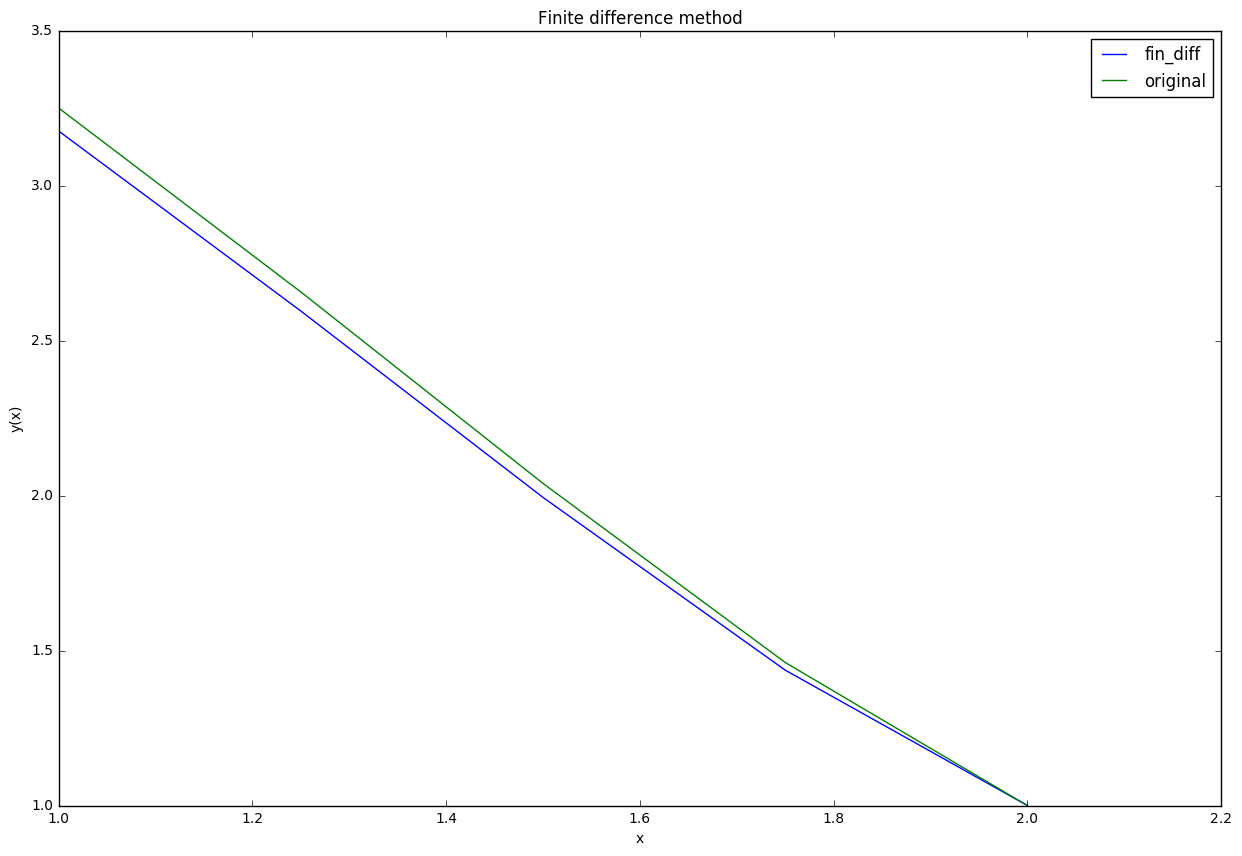

In [5]:
y = fin_diff(x, p(x), q(x), f(x), alpha, beta, gamma, delta, ya, yb)
y_ans = x**4/8 - 11/8*x**2 + 9/2

plt.figure(figsize=(15, 10))
plt.plot(x, y, x, y_ans)
plt.legend(['fin_diff', 'original'], loc='best')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.title('Finite difference method')
plt.show()

## Shooting method

In [6]:
def fmap(fs, x):
    return np.array([f(*x) for f in fs])

In [7]:
def runge_kutta4_system(fs, x, y0):
    h = x[1] - x[0]
    y = np.ndarray((len(x), len(y0)))
    y[0] = y0
    for i in range(1, len(x)):
        k1 = h * fmap(fs, [x[i - 1], *y[i - 1]])
        y[i] = y[i - 1] + k1
    return y

In [8]:
def shooting(x, p, q, f, ya, yb):
    dy = lambda x, y, z: z
    dz = lambda x, y, z: -p(x)*z - q(x)*y + f(x)
    g = lambda alpha: runge_kutta4_system([dy, dz], x, [ya, np.tan(alpha)])[-1][0] - yb
    alpha = scipy.optimize.bisect(g, 0, np.pi/2)
    return runge_kutta4_system([dy, dz], x, [ya, np.tan(alpha)])[:, 0]

## Example
Let's solve the next problem:
$$
y'' = \frac{1}{x}y' + x^2,\\
y(1) = 0,\\
y(2) = 1
$$
having $[a, b] = [1, 2], h = 0.25$.

Correct solution is
$$y(x) = \frac{1}{24}(3x^4 - 7x^2 + 4)$$

In [9]:
p = np.vectorize(lambda x: -1/x)
q = np.vectorize(lambda x: 0)
f = np.vectorize(lambda x: x*x)
a, b = 1, 2
ya, yb = 0, 1
x = np.linspace(a, b, 5)

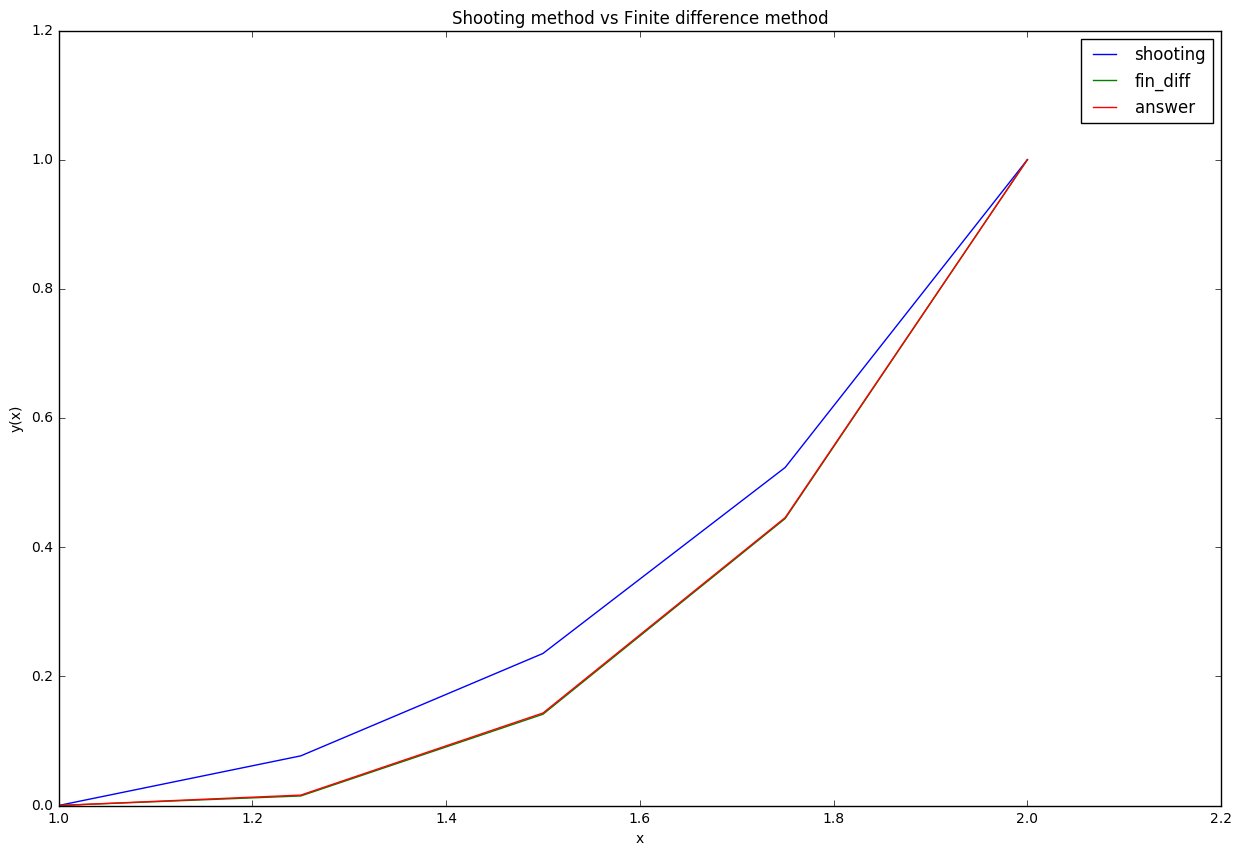

In [10]:
y = shooting(x, p, q, f, ya, yb)
y_diff = fin_diff(x, p(x), q(x), f(x), 0, 1, 0, 1, ya, yb)
y_ans = (3*x**4 - 7*x**2 + 4)/24

plt.figure(figsize=(15, 10))
plt.plot(x, y, x, y_diff, x, y_ans)
plt.legend(['shooting', 'fin_diff', 'answer'], loc='best')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.title('Shooting method vs Finite difference method')
plt.show()